# Data Preparation

Create the data needed to make and run our engine. We'll make an intermediate model that predicts if Phil will see his shadow based on the temperature data from Pennsylvania and the Northeast. Then, use that to make predictions over a broader range of data.

## Clean and Format Data

In [1]:
import pandas as pd

### Load Data

Load the data from the CSV and use more terse column names.

In [2]:
df_phil = pd.read_csv('data/raw/punxsutawney-predictions.csv', encoding='utf-8')
df_phil.columns = [
    'year', 'shadow', 
    'feb_temp', 'feb_temp_ne', 'feb_temp_mw', 'feb_temp_pa',
    'mar_temp', 'mar_temp_ne', 'mar_temp_mw', 'mar_temp_pa']

In [3]:
df_phil

,year,shadow,feb_temp,feb_temp_ne,feb_temp_mw,feb_temp_pa,mar_temp,mar_temp_ne,mar_temp_mw,mar_temp_pa
0,1898,Full Shadow,35.37,24.8,33.3,26.7,41.05,38.0,46.0,42.0
1,1900,Full Shadow,30.76,21.4,27.5,24.1,41.27,26.0,37.9,29.3
2,1901,Full Shadow,29.86,16.0,26.2,18.9,40.71,30.8,41.9,35.1
3,1903,Full Shadow,28.42,24.5,31.3,28.0,42.21,40.4,47.7,44.5
4,1904,Full Shadow,31.59,15.0,28.2,19.2,41.76,29.8,42.8,34.0
...,...,...,...,...,...,...,...,...,...,...
110,2012,Full Shadow,37.51,30.6,38.6,34.3,50.41,43.4,56.3,47.7
111,2013,No Shadow,34.77,25.3,33.4,27.4,40.91,32.7,37.3,33.9
112,2014,Full Shadow,32.13,21.0,27.1,22.8,40.51,26.0,38.0,30.3
113,2015,Full Shadow,32.99,12.1,23.4,16.1,45.39,27.8,41.6,31.6


### Filter Columns

Select just the columns we need for our model and make the column names more focused.

In [4]:
df_filtered = df_phil.filter(items=['shadow', 'feb_temp_pa', 'feb_temp_ne', 'mar_temp_pa', 'mar_temp_ne'])
df_filtered.columns = ['shadow', 'feb_state_temp', 'feb_region_temp', 'mar_state_temp', 'mar_region_temp']

In [5]:
df_filtered

,shadow,feb_state_temp,feb_region_temp,mar_state_temp,mar_region_temp
0,Full Shadow,26.7,24.8,42.0,38.0
1,Full Shadow,24.1,21.4,29.3,26.0
2,Full Shadow,18.9,16.0,35.1,30.8
3,Full Shadow,28.0,24.5,44.5,40.4
4,Full Shadow,19.2,15.0,34.0,29.8
...,...,...,...,...,...
110,Full Shadow,34.3,30.6,47.7,43.4
111,No Shadow,27.4,25.3,33.9,32.7
112,Full Shadow,22.8,21.0,30.3,26.0
113,Full Shadow,16.1,12.1,31.6,27.8


### Understand Our Data

In [6]:
df_filtered.shadow.value_counts()

Full Shadow    100
No Shadow       15
Name: shadow, dtype: int64

In [7]:
df_filtered.shadow.value_counts(normalize=True)

Full Shadow    0.869565
No Shadow      0.130435
Name: shadow, dtype: float64

array([[<AxesSubplot:title={'center':'feb_state_temp'}>,
        <AxesSubplot:title={'center':'feb_region_temp'}>],
       [<AxesSubplot:title={'center':'mar_state_temp'}>,
        <AxesSubplot:title={'center':'mar_region_temp'}>]], dtype=object)

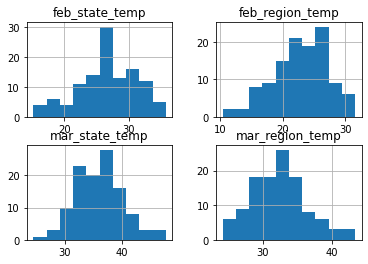

In [8]:
df_filtered.hist()

shadow
Full Shadow    [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
No Shadow      [[AxesSubplot(0.125,0.551739;0.336957x0.328261...
dtype: object

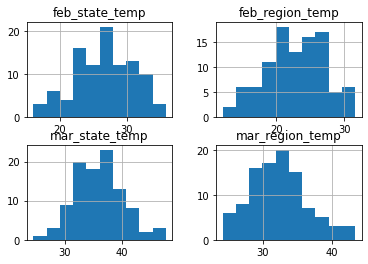

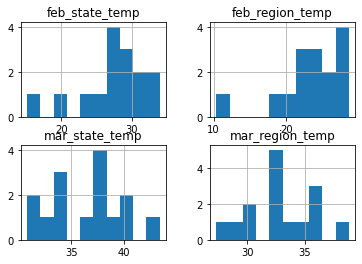

In [9]:
df_filtered.groupby('shadow').hist()

### Targets & Features

Get the values for the target and the features.

In [10]:
df_target = df_filtered.iloc[:, 0]
df_features = df_filtered.iloc[:, 1:].astype(float)

X, y = df_features.values, df_target.values

In [11]:
X.shape, y.shape

((115, 4), (115,))

### Balancing Our Data

Our data is way out of balance. Balance it to improve the results of our model.

In [12]:
from imblearn.over_sampling import RandomOverSampler

In [13]:
oversampler = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversampler.fit_resample(X, y)

In [14]:
X_over.shape, y_over.shape

((200, 4), (200,))

## Build Some Models

In [15]:
import pickle

models = []

### Train/Test Split

Split the training and testing data 80/20.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, train_size=0.80, test_size=0.20, random_state=0)

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 4), (40, 4), (160,), (40,))

### Train a Support Vector Machine

In [19]:
from sklearn.svm import LinearSVC

In [20]:
svm = LinearSVC(dual=False, random_state=0).fit(X_train, y_train)

In [21]:
score = svm.score(X_test, y_test)
models.append((score, 'Support Vector Machine', svm))
score

0.625

In [22]:
with open('model/punxsutawney-svm.pickle', 'wb') as file:
  pickle.dump(svm, file)

### Train a Logistic Regresion

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=0).fit(X_train, y_train)

In [25]:
score = lr.score(X_test, y_test)
models.append((score, 'Logistic Regression', lr))
score

0.6

In [26]:
with open('model/punxsutawney-lr.pickle', 'wb') as file:
  pickle.dump(lr, file)

### Train a Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0).fit(X_train, y_train)

In [29]:
score = rf.score(X_test, y_test)
models.append((score, 'Random Forest', rf))
score

0.875

In [30]:
with open('model/punxsutawney-rf.pickle', 'wb') as file:
  pickle.dump(rf, file)

### Select a Model

Select the model with the highest score.

In [31]:
models.sort(reverse=True)
models

[(0.875, 'Random Forest', RandomForestClassifier(max_depth=5, random_state=0)),
 (0.625, 'Support Vector Machine', LinearSVC(dual=False, random_state=0)),
 (0.6,
  'Logistic Regression',
  LogisticRegression(multi_class='ovr', random_state=0))]

In [32]:
model = models[0][2]
model

RandomForestClassifier(max_depth=5, random_state=0)

In [33]:
with open('model/punxsutawney.pickle', 'wb') as file:
  pickle.dump(model, file)

## Merge Data

Blend all the state, region, and temperature data into a single dataset. But only where groundhogs are found.

### Regions with Groundhogs

We'll just hard-code this.

In [34]:
regions_with_groundhogs = ['Upper Midwest', 'Ohio Valley', 'Northeast']

### Read in State Data

We only care about regions with ground hogs so filter the others out.

In [35]:
df_states = pd.read_csv('data/raw/states.csv', encoding='utf-8')
df_states = df_states.loc[df_states['region'].isin(regions_with_groundhogs)]
df_states

,state,latitude,longitude,region
5,Connecticut,41.6219,-72.7273,Northeast
6,Delaware,38.9896,-75.5050,Northeast
10,Illinois,40.0417,-89.1965,Ohio Valley
11,Indiana,39.8942,-86.2816,Ohio Valley
12,Iowa,42.0751,-93.4960,Upper Midwest
14,Kentucky,37.5347,-85.3021,Ohio Valley
16,Maine,45.3695,-69.2428,Northeast
17,Maryland,39.0550,-76.7909,Northeast
18,Massachusetts,42.2596,-71.8083,Northeast
19,Michigan,44.3467,-85.4102,Upper Midwest


### Find States with Groundhogs

Let's get a list of states with ground hogs from this newly filtered list.

In [36]:
states_with_groundhogs = df_states['state'].values
states_with_groundhogs

array(['Connecticut', 'Delaware', 'Illinois', 'Indiana', 'Iowa',
       'Kentucky', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Missouri', 'New Hampshire', 'New Jersey', 'New York',
       'Ohio', 'Pennsylvania', 'Rhode Island', 'Tennessee', 'Vermont',
       'West Virginia', 'Wisconsin'], dtype=object)

### Load Region Temperature Data

And filter out regions without groundhogs.

In [37]:
df_avg_region = pd.read_csv('data/raw/average-monthly-temperatures-by-region.csv', encoding='utf-8')
df_avg_region = df_avg_region.filter(items=['Location', 'Date', 'Value'])
df_avg_region.columns = ['region', 'month', 'region_temp']
df_avg_region = df_avg_region.loc[df_avg_region['region'].isin(regions_with_groundhogs)]
df_avg_region

,region,month,region_temp
0,Northeast,189501,18.8
1,Northeast,189502,15.6
2,Northeast,189503,27.6
3,Northeast,189504,43.5
4,Northeast,189505,57.1
...,...,...,...
4528,Ohio Valley,202007,77.8
4529,Ohio Valley,202008,73.6
4530,Ohio Valley,202009,66.6
4531,Ohio Valley,202010,54.8


### Load State Temperature Data

And filter out the states we don't care about. In otherwords, states without groundhogs.

In [38]:
df_avg_state = pd.read_csv('data/raw/average-monthly-temperatures-by-state.csv', encoding='utf-8')
df_avg_state = df_avg_state.filter(items=['Location', 'Date', 'Value'])
df_avg_state.columns = ['state', 'month', 'state_temp']
df_avg_state = df_avg_state.loc[df_avg_state['state'].isin(states_with_groundhogs)]
df_avg_state

,state,month,state_temp
7555,Connecticut,189501,22.8
7556,Connecticut,189502,18.7
7557,Connecticut,189503,31.5
7558,Connecticut,189504,44.5
7559,Connecticut,189505,57.8
...,...,...,...
71012,Wisconsin,202007,72.0
71013,Wisconsin,202008,68.4
71014,Wisconsin,202009,57.4
71015,Wisconsin,202010,41.2


### Merge State & Region Data

Separate the year from the month, filter out everything but February and March, and then flatten the two months together.

We'll need a list of months to decoded the month in the data.

In [39]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Merge state and region data.

In [40]:
df_merged = df_avg_state.merge(df_states, on='state').merge(df_avg_region, on=['region', 'month'])

Take the month column and break it into year and and month.

In [41]:
df_merged['year'] = df_merged['month'].transform(lambda yyyymm: yyyymm // 100).astype(str)
df_merged['month'] = df_merged['month'].transform(lambda yyyymm: months[yyyymm % 100 - 1])

Filter out months that aren't six weeks after Groundhog Day.

In [42]:
df_merged = df_merged.loc[df_merged['month'].isin(['Feb', 'Mar'])]

### Flatten Monthly Temperatures

Flatten monthly temperatures so we have one record per year with temperatures for just February and March.

Get February records and columns.

In [43]:
df_feb = df_merged.loc[df_merged['month'] == 'Feb']
df_feb = df_feb.filter(items=['year', 'state', 'region', 'latitude', 'longitude', 'state_temp', 'region_temp'])
df_feb.columns = ['year', 'state', 'region', 'latitude', 'longitude', 'feb_state_temp', 'feb_region_temp']

Get March records and columns.

In [44]:
df_mar = df_merged.loc[df_merged['month'] == 'Mar']
df_mar = df_mar.filter(items=['year', 'state', 'region', 'latitude', 'longitude', 'state_temp', 'region_temp'])
df_mar.columns = ['year', 'state', 'region', 'latitude', 'longitude', 'mar_state_temp', 'mar_region_temp']

Merge February and March records.

In [45]:
df_feb_mar = df_feb.merge(df_mar, on=['year', 'state', 'region', 'latitude', 'longitude'])
df_feb_mar = df_feb_mar.filter(items=['state', 'region', 'latitude', 'longitude',
                                      'feb_state_temp', 'feb_region_temp',
                                      'mar_state_temp', 'mar_region_temp'])

In [46]:
df_feb_mar

,state,region,latitude,longitude,feb_state_temp,feb_region_temp,mar_state_temp,mar_region_temp
0,Connecticut,Northeast,41.6219,-72.7273,18.7,15.6,31.5,27.6
1,Delaware,Northeast,38.9896,-75.5050,24.2,15.6,39.5,27.6
2,Maine,Northeast,45.3695,-69.2428,11.8,15.6,21.3,27.6
3,Maryland,Northeast,39.0550,-76.7909,23.6,15.6,39.3,27.6
4,Massachusetts,Northeast,42.2596,-71.8083,18.5,15.6,30.8,27.6
...,...,...,...,...,...,...,...,...
2767,Wisconsin,Upper Midwest,44.6243,-89.9941,13.5,12.6,25.7,26.3
2768,Iowa,Upper Midwest,42.0751,-93.4960,24.8,19.7,40.3,34.5
2769,Michigan,Upper Midwest,44.3467,-85.4102,23.6,19.7,35.0,34.5
2770,Minnesota,Upper Midwest,46.2807,-94.3053,14.0,19.7,30.4,34.5


## Predict for All the States

Using the first model, predict Shadow/No Shadow for al the data above. Build a file of lattitude, longitude, state temperatures, regional temperatures, and shadow.

### Predict

In [47]:
X = df_feb_mar.iloc[:, 4:].values
y = model.predict(X)

X.shape, y.shape

((2772, 4), (2772,))

### Merge Predictions

In [48]:
df_output = pd.concat([pd.DataFrame(y), df_feb_mar], axis=1)
df_output.columns = ['shadow', 'state', 'region', 'latitude', 'longitude',
                     'feb_state_temp', 'feb_region_temp', 'mar_state_temp', 'mar_region_temp']
df_output

,shadow,state,region,latitude,longitude,feb_state_temp,feb_region_temp,mar_state_temp,mar_region_temp
0,Full Shadow,Connecticut,Northeast,41.6219,-72.7273,18.7,15.6,31.5,27.6
1,Full Shadow,Delaware,Northeast,38.9896,-75.5050,24.2,15.6,39.5,27.6
2,Full Shadow,Maine,Northeast,45.3695,-69.2428,11.8,15.6,21.3,27.6
3,Full Shadow,Maryland,Northeast,39.0550,-76.7909,23.6,15.6,39.3,27.6
4,Full Shadow,Massachusetts,Northeast,42.2596,-71.8083,18.5,15.6,30.8,27.6
...,...,...,...,...,...,...,...,...,...
2767,Full Shadow,Wisconsin,Upper Midwest,44.6243,-89.9941,13.5,12.6,25.7,26.3
2768,Full Shadow,Iowa,Upper Midwest,42.0751,-93.4960,24.8,19.7,40.3,34.5
2769,Full Shadow,Michigan,Upper Midwest,44.3467,-85.4102,23.6,19.7,35.0,34.5
2770,Full Shadow,Minnesota,Upper Midwest,46.2807,-94.3053,14.0,19.7,30.4,34.5


## Save Data

Save the newly minted data.

In [49]:
df_output.to_csv('data/imputed/state-predictions.csv', index=False)